<a href="https://colab.research.google.com/github/GDharan10/MachineLearningAlgorithmFromScratch/blob/main/Tree-Based%20Algorithms%20/%20DecisionTreesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Overview**

**Used for predicting categorical values.**

Decision Trees are versatile supervised learning algorithms used for both classification and regression tasks. They partition the data into subsets based on the features and recursively split the data into smaller subsets until the data in each subset is homogeneous with respect to the target variable. The goal is to create a tree that predicts the target variable by learning simple decision rules inferred from the data features.




# **How It Works**

Decision Trees work by recursively partitioning the data based on the feature that best separates the data at each node. Each internal node represents a "decision" based on a feature, and each leaf node represents the target variable's value. The tree is built using algorithms that select the best feature to split the data at each step, typically based on metrics like information gain or Gini impurity.

# **Background Python Code**
Below is the Python code for implementing linear regression from scratch.

In [ ]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature              # Feature index used for splitting
        self.threshold = threshold          # Threshold value for splitting
        self.left = left                    # Left child node
        self.right = right                  # Right child node
        self.value = value                  # Value if the node is a leaf node

    def is_leaf_node(self):
        return self.value is not None       # Check if the node is a leaf node


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split  # Minimum samples required to split a node
        self.max_depth = max_depth                  # Maximum depth of the tree
        self.n_features = n_features                # Number of features to consider for splitting
        self.root = None                            # Root node of the tree

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)  # Grow the tree from the root

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape              # Number of samples and features
        n_labels = len(np.unique(y))              # Number of unique labels

        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)  # Determine the leaf node value
            return Node(value=leaf_value)           # Return a leaf node

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)  # Randomly select features

        best_feature, best_thresh = self._best_split(X, y, feat_idxs)  # Find the best feature and threshold for splitting

        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)  # Split the data
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)        # Grow the left subtree
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)     # Grow the right subtree
        return Node(best_feature, best_thresh, left, right)                   # Return the current node

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1                            # Initialize best gain to a very low value
        split_idx, split_threshold = None, None   # Initialize split index and threshold

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]            # Get column of the current feature
            thresholds = np.unique(X_column)     # Get unique values of the feature

            for thr in thresholds:
                gain = self._information_gain(y, X_column, thr)  # Calculate information gain

                if gain > best_gain:             # Update best gain and split parameters if current gain is better
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold        # Return the best feature index and threshold

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)        # Calculate entropy of the parent node

        left_idxs, right_idxs = self._split(X_column, threshold)  # Split the data

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0                             # Return zero gain if any split is empty

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)            # Number of samples in left and right splits
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])  # Entropy of left and right splits
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r          # Weighted average entropy of children

        information_gain = parent_entropy - child_entropy      # Calculate information gain
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()   # Indices of samples in the left split
        right_idxs = np.argwhere(X_column > split_thresh).flatten()   # Indices of samples in the right split
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)                   # Count occurrences of each class
        ps = hist / len(y)                      # Probabilities of each class
        return -np.sum([p * np.log(p) for p in ps if p > 0])  # Calculate entropy

    def _most_common_label(self, y):
        counter = Counter(y)                    # Count occurrences of each label
        value = counter.most_common(1)[0][0]    # Find the most common label
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])  # Predict labels for all samples

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value                   # Return the value if it's a leaf node

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)  # Traverse the left subtree if the condition is true
        return self._traverse_tree(x, node.right)     # Traverse the right subtree otherwise

    def visualize(self):
        from graphviz import Digraph

        def add_nodes_edges(dot, node, counter=0):
            if node.is_leaf_node():
                dot.node(name=str(counter), label=str(node.value), shape='box')  # Create a leaf node
                return counter

            dot.node(name=str(counter), label=f'X{node.feature} <= {node.threshold:.2f}')  # Create a decision node
            left_counter = counter + 1
            right_counter = add_nodes_edges(dot, node.left, left_counter)  # Add left child nodes and edges
            dot.edge(str(counter), str(left_counter), 'True')
            dot.edge(str(counter), str(right_counter + 1), 'False')
            return add_nodes_edges(dot, node.right, right_counter + 1)     # Add right child nodes and edges

        dot = Digraph()
        add_nodes_edges(dot, self.root)           # Start adding nodes and edges from the root
        return dot                                # Return the visualization


# **Comparing the Algorithm with the Class**

The Node class represents nodes in the Decision Tree, where each node either has a split condition (feature, threshold) or a leaf value.

The DecisionTree class implements the Decision Tree algorithm, allowing training (fitting) on data and making predictions. Here’s a breakdown of its components:

1. **Node Class (Node):**

 * **Attributes:**

    * **feature:** Index of the feature used for splitting at this node.
    * **threshold:** Threshold value for the split.
    * **left, right:** Child nodes (subtrees) for the left and right splits.
    * **value:** Leaf node value if the node is a leaf.

 * **Methods:**

    * **is_leaf_node():** Checks if the current node is a leaf node.

2. **DecisionTree Class (DecisionTree):**

 * **Attributes:**

    * **min_samples_split:** Minimum number of samples required to split an internal node.
    * **max_depth:** Maximum depth of the tree.
    * **n_features:** Number of features to consider when looking for the best split.
    * **root:** Root node of the Decision Tree.

 * **Methods:**

    * **fit(X, y):** Trains the Decision Tree using the provided features (X) and labels (y).
    * **_grow_tree(X, y, depth):** Recursively grows the Decision Tree by finding the best split at each node.
    * **_best_split(X, y, feat_idxs):** Finds the best feature and threshold to split the data based on information gain.
    * **_information_gain(y, X_column, threshold):** Calculates the information gain when splitting based on a specific feature and threshold.
    * **_split(X_column, split_thresh):** Splits the data into left and right indices based on a feature's threshold.
    * **_entropy(y):** Calculates the entropy of the target variable y.
    * **_most_common_label(y):** Returns the most common label in y.
    * **predict(X):** Predicts the target variable for new data points X using the trained Decision Tree.
    * **_traverse_tree(x, node):** Traverses the Decision Tree from the root node to make predictions for a single data point x.

**Summary:**
 * **Node Class:** Represents nodes in the Decision Tree structure, either with split conditions or leaf values.
 * **DecisionTree Class:** Implements the Decision Tree algorithm including tree growing, splitting criteria (information gain), entropy calculation, and prediction traversal.

# **Explanation of the fit method**


## **Initial Setup**



In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Load the Iris dataset
data = datasets.load_iris()
X, y = data.data, data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)


**Sample:**
5.1, 2.5, 3.0, 1.1

**Label:**
1

---

**Root Node Split (root_node)**

**Feature 2 (Petal Length) with Threshold 3.5:**
Since 3.0 ≤ 3.5, the sample goes to the left child.

**Left Child Node Split (left_child_node1)**

**Feature 3 (Petal Width) with Threshold 1.0:**
Since 1.1 > 1.0, the sample goes to the right child.

**Right Child Node (right_child_node)**

**Feature 0 (Sepal Length) with Threshold 5.5:**
Since 5.1 ≤ 5.5, the sample goes to the left child.

**Left Child Node Split (left_child_node2)**

**Feature 1 (Sepal Width) with Threshold 3.0:**
Since 2.5 ≤ 3.0, the sample goes to the left child.

**Leaf Node (leaf_node)**

The sample reaches a leaf node (leaf_node), where the majority class label is assigned (in this case, let's assume it's 1).

---

**Explanation of Decision Tree Process for Feature 2 (Petal Length) and Threshold 3.5**

**Root Node (root_node):**

- **Feature:** X2 (Petal Length)
- **Threshold:** 3.5
- **Decision:** If X2 (Petal Length) ≤ 3.5, go to the left child; otherwise, go to the right child.

**How the Best Feature (Petal Length) and Threshold (3.5) are Found:**

**Initialization:**

The decision tree starts by considering all features for potential splits.

**Feature Selection (split_idx):**

It evaluates each feature (X2, X3, X0, X1) to find the one that provides the highest information gain (best_gain) when used as a splitting criterion.

**Information Gain Calculation (information_gain):**

For X2 (Petal Length):
It evaluates various thresholds (unique values in the Petal Length column) to determine which split provides the best separation of classes (labels).

**Best Threshold Determination (split_threshold):**

Among all evaluated thresholds for X2 (Petal Length), the threshold 3.5 is chosen because it maximizes the information gain (best_gain).

**Decision Criteria:**

Once the best feature (split_idx - X2 - Petal Length) and threshold (split_threshold - 3.5) are determined:
- If a sample's Petal Length value (X2) is less than or equal to 3.5, it follows the left child path.
- If it's greater than 3.5, it follows the right child path.

**Conclusion:**

This process continues recursively for each node in the decision tree until leaf nodes (leaf_node) are reached, where predictions (in this case, class labels) are made based on majority voting or other criteria defined by the model.


# **Implementation and Visualization**

## **Multi-class classification**

Accuracy: 1.00


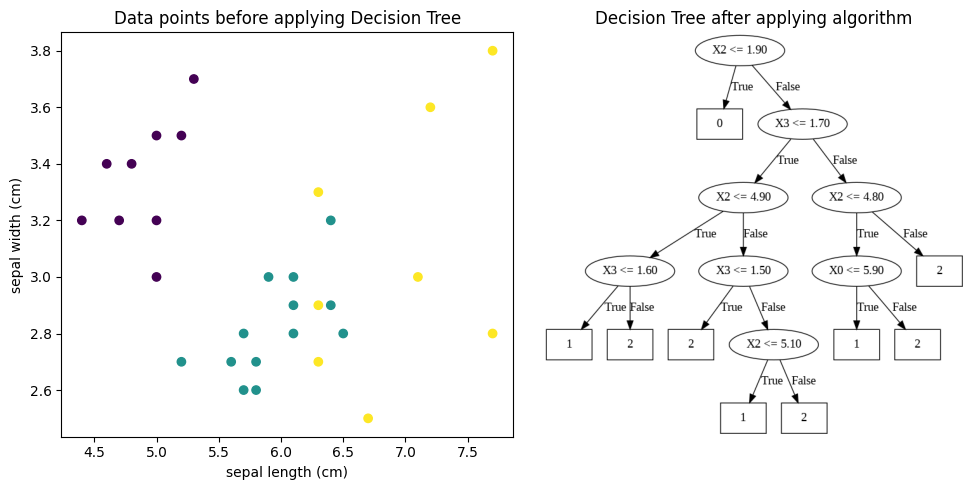

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Load the Iris dataset
data = datasets.load_iris()
X, y = data.data, data.target

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Fit the model
clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

# Calculate accuracy
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(y_test, predictions)
print(f'Accuracy: {acc:.2f}')

# Visualize the data points (using only two features for visualization purposes)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis')
plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])
plt.title('Data points before applying Decision Tree')

# Visualize the decision tree
plt.subplot(1, 2, 2)
tree_plot = clf.visualize()
tree_plot.render('decision_tree', format='png')
plt.imshow(plt.imread('decision_tree.png'))
plt.axis('off')
plt.title('Decision Tree after applying algorithm')

plt.tight_layout()
plt.show()

## **Binary-class classification**

Accuracy: 0.92


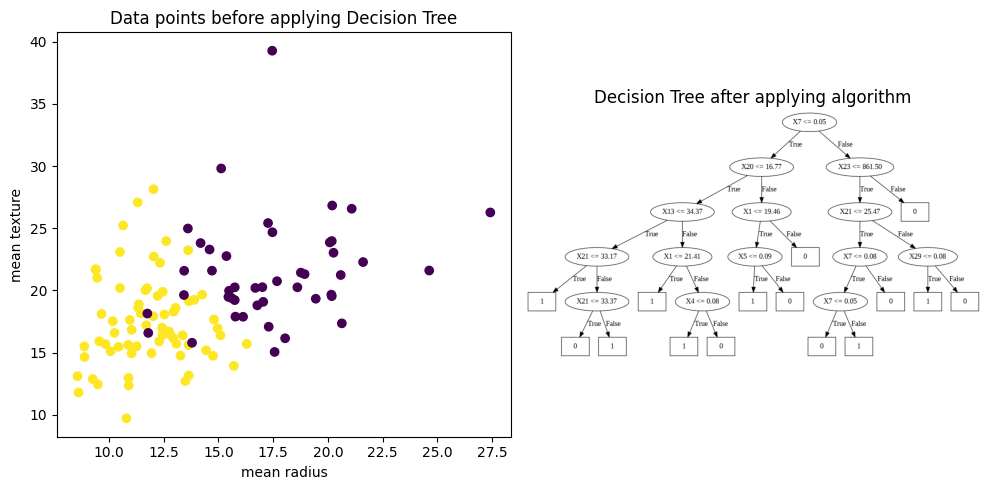

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Load the dataset
data = datasets.load_breast_cancer()
X, y = data.data, data.target

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Fit the model
clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

# Calculate accuracy
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(y_test, predictions)
print(f'Accuracy: {acc:.2f}')

# Visualize the data points (using only two features for visualization purposes)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis')
plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])
plt.title('Data points before applying Decision Tree')

# Visualize the decision tree
plt.subplot(1, 2, 2)
tree_plot = clf.visualize()
tree_plot.render('decision_tree', format='png')
plt.imshow(plt.imread('decision_tree.png'))
plt.axis('off')
plt.title('Decision Tree after applying algorithm')

plt.tight_layout()
plt.show()


# **Implementation Details**

# **Key Considerations for DecisionTrees Modeling:**